# Descripción del Problema


La creciente generación de datos de texto (no estructurados o semi estructurados) conduce a la necesidad de crear y
mejorar técnicas de almacenamiento, exploración y manipulación de los datos, para la extracción y recuperación de
información significativa en contextos como los de una compañía o la academia. Así, la analítica de texto surge con el
interés de buscar y obtener nueva información dentro de los datos de texto.
Las computadoras no pueden procesar, y mucho menos analizar o extraer información, de los datos texto. Por esto, es
imprescindible estructurar y representar el texto en forma numérica, dicho de otra forma, traducirlo al lenguaje de la
computadora (Jo, 2018). Entonces es así, como el Procesamiento del Languaje Natural, NLP (por sus siglas en inglés
“Natural Lenguage Processing”), se convierte en el puente para procesar el texto en una maquina; su área de estudio,
perteneciendo a la rama de la Inteligencia Artificial, se encarga de la formulación de mecanismos computacionales que
permiten la comunicación entre personas y máquinas, mediante “Lenguajes Naturales”, los cuales son lo que se usan en
la comunicación entre personas, ya sea escrito, hablado o signado (Chopra, Joshi, y Mathur, 2016).
Ahora, de acuerdo con la información que se requiera extraer en los datos de texto, se han definido diferentes líneas
de trabajo (Hardeniya, Perkins, Chopra, Joshi, y Mathur, 2016), algunas de ellas son la Minería de Texto, el Análisis
de Sentimientos y de Comentarios, el ntendimiento natural del lenguaje o el desarrollo de buscadores como Google

También, dentro de cada línea se han adoptado diferentes técnicas para mejorar la extracción de la información deseada
tal como predicciones, tendencias, indicadores, reportes, entre otros.
No obstante, sin importar la línea de trabajo, uno de los retos más importantes que se imponen a la hora de trabajar
con datos de texto, es su preparación, pues como se menciona anteriormente, las computadoras no pueden descifrar
sus propiedades como la sintaxis, semántica, morfología, entre otras, lo que también se debe, a que el lenguaje natural
carece de una única norma uniforme de escritura, cuya representación sea natural dentro del lenguaje de la computadora.
En consecuencia, la preparación de los datos es el primer procedimiento indispensable dentro del Procesamiento del
Lenguaje Natural (Jo, 2018).
Durante la preparación de los datos se desea: (1) reducir el espacio de almacenamiento, (2) estructurar los datos
representándolos en forma numérica, y (3) determinar una forma de representar los datos que esté en consonancia con
objetivo de su procesamiento para minimizar la complejidad en su posterior manipulación (Feldman y Sanger, 2007;
Croft, Metzler, y Strohman, 2010; Cady, 2017; Jo, 2018).
Cabe enfatizar la importancia, de que, en esta primera etapa, se tenga en especial consideración el beneficio que se desea
extraer al final de todo el proceso (NLP), ya que de lo contrario, se corre el riesgo de: (1) eliminar o conservar datos
necesarios o irrelevantes, respectivamente, y (2) de estructurar y representar los datos (depurados) en arreglos y valores
de forma inadecuada, dado que, en caso de que se materialice lo anterior, el posterior procesamiento o interpretación de
los datos carecrá de validez.
Se puede decir entonces, que la calidad de la información extraída del procesamiento de texto, es altamente dependiente
de la rigurosidad y la calidad con que se hayan empleado las técnicas de preparación de los datos en su preprocesamiento
(Feldman y Sanger, 2007), cuyo uso depende de cómo se aborde el problema. Una de las técnicas más comunes es la
indexación de texto.
La indexación de texto consiste en generar una o varias listas de elementos que son relevantes para el conjunto de datos,
por ejemplo, una lista con las palabras más importantes de un texto, tal que de ellas, se pueda inferir el tema que se
aborda en el escrito. Esta técnica consiste en aplicar la siguiente serie de pasos al texto (Cady, 2017; Feldman y Sanger,
2007; Jo, 2018; Croft y cols., 2010).



1. Limpieza: se refiere a la eliminación de información que se considera ``irrelevante'' dentro del contexto de los datos obtenidos. 
1. Tokenización: es la separación de elementos dentro de un texto (palabras, párrafos, frases, etc.). 
1. Stemming: busca llevar las palabras a su raíz.  
1. Lematización: es llevar las palabras a su forma canónica.
1. Eliminación de stopwords: hace referencia a la remoción de palabras, que en general, se considera que no aportan información, como como por ejemplo los conectores (artículos, preposiciones, entre otros).
1. Ponderación de términos: es la identificación y asignación de la importancia a las palabras del vocabulario.


Por último, después de la indexación del texto y como paso final del proceso de preparación de los datos, se hace
posible estructurar/representar los datos en arreglos como matrices, listas o grafos, de acuerdo con el objeto de estudio e
información que se desee obtener.
Por ejemplo, el Bag of Words es una representación matricial donde se estructuran los datos indexados (Hardeniya y
cols., 2016). Las filas de la matriz corresponden a los documentos de texto adquiridos (tuits, artículos académicos, notas,
mensajes, entre otros), y las columnas corresponden a las palabras o grupos de palabras, más importantes dentro del
conjunto de documentos. Así, los elementos de la matriz asocian la existencia (1) o inexistencia (0) de una palabra en un
documento específico. Cabe aclarar, que los elementos de la matriz no tienen que ser binarios (existencia o inexistencia),
también puede representar la frecuencia de una palabra en un documento, la importancia de la palabra dentro del
documento de acuerdo con al número de veces que aparece en todos los documentos, etc.; es decir, la representación
numérica de cada elemento de la matriz puede ser determinada a criterio de quienes procesan los datos1
(Hardeniya y
cols., 2016).
Finalmente, a lo largo de este trabajo, se describirá la etapa de preparación general de datos de texto, usando la técnica
de indexación de texto y la representación de datos bajo el concepto del Bag of Words. Todo esto, en coherencia con el
problema que se plantea a continuación en el marco del “Proyecto Integrador 1: Procesamiento de Texto”
.

## Análisis de tópicos  

Partiendo del objetivo del trabajo final de la materia de Almacenamiento y recuperación de la información, el cual consiste en hacer un análisis de exhaustivo sobre tópicos y sentimientos de la base de datos semiestructurada “news.csv”, se hace importante reconocer que este tipo de estudios tienen como finalidad extraer información sobre la polaridad del texto, en este caso de estudio, las noticias de en “news.csv”.  

Así entonces, en primera instancia se hace un análisis de tópicos que tiene como objetivo general el reconocer los temas presentes en un conjunto de texto. Una de las metodologías más usadas para ello es el LDA. En particular esta consiste en reconocer cada texto como una mezcla al azar sobre los temas latentes en el conjunto de textos (o documentos), y cada tema se caracteriza por una distribución de Dirichlet de parámetros óptimos.  

<img src="pseudocodigo.png">
(Tomado de Andrades y López, 2011). 

Luego, para cada uno de los documentos, se busca el tema que le fue asignado. Esto se hace, como se menciona anteriormente, eligiendo una mezcla aleatoria de palabras para cada documento, que, al iterar sobre la mezcla, a mayor cantidad de palabras parecidas a un tópico, la probabilidad de que el documento lo contenga aumenta (Benítez, Valbuena, 2011).  

Andrades, J. A. B., & López, J. A. V. (2011). Motores de Búsqueda Web: Estado del arte en Probabilistic Latent Semantic Analysis y en Latent Dirichlet Allocation aplicado a problemas de acceso a la información en la Web. 

## Análisis de sentimientos 

El análisis de sentimientos puede verse desde dos enfoques globales (Liu, 2012). Uno de ellos consiste en el método de palabras asociadas (Pang, Lee, and Vaithyanathan, 2002), el cual toma el contexto del documento que contiene la palabra, en la frese, párrafo, etc., pudiendo discriminar el “sentimiento” o sentido detrás de cada n-gram. El segundo enforque, el cual se presenta en el caso de estudio, consiste en el análisis de la semántica (Turney, 2002) que muestra orientación o polaridad de un texto como una opinión. En esta metodología es necesario el procesamiento de indexación (mínimamente básico) del texto, con el fin de comparar los tokens con un diccionario indexado (lexicon) que contiene términos de polaridad positiva, negativa y neutra (apolar). Normalmente los sistemas incluyen tratamientos más avanzados ya que también contienen temimos modificadores (intensifican la polaridad de un término) o inversores (cambian al sentido contrario la palabra polarizada). Finalmente, la sumatoria de las polaridades da una aproximación global del “sentimiento” del conjunto de palabras consecutivas (frase), siendo globalmente positiva, negativa o neutra.

# Referencias

Liu, B. (2012). Sentiment analysis and opinion mining. Synthesis lectures on human language technologies, 5(1), 1-167. 

Pang, B., & Lee, L. (2008). Opinion mining and sentiment analysis. Foundations and Trends® in Information Retrieval, 2(1–2), 1-135. 

Turney, P. Semantic Orientation Applied to Unsupervised Classification of Reviews. In Proceedings of ACL-02, 40th Annual Meeting of the Association for Computational Linguistics(pp. 417-424). 

# Step by step (Resumen)

- se lanza un cluster en aws.
- la conexión se hace por consola y ssh al cluster desde el pc personal
- se procede a la instalación de jupyterhub y se clona el [repositorio](https://github.com/camilaMejia/trabajoFinal) del proyecto. con este notebook listo (En el github hay un archivo que se llama launch.txt donde están todas las instrucciones que se lanzan por comando)
- se instalan y cargan todas las librerías necesarias.
- se trae él .dat y el .csv desde S3 al almacenamiento local.
- se crea el índice invertido usando metapy.
- se hace el querying usando BM25.
- Se hace un LDA con todas las noticias (solo content + title).
- Para cada noticia se ve cual es el tópico dominante.
- se procede a la asignación de la polaridad de cada noticia utilizando textBlob.



# Procedimiento en AWS

Uno de los objetivos de este trabajo es evaluar la posibilidad de correr el proceso en máquinas virtuales y clusters de AWS. Para ello, se crea un cluster a traves de EMR y luego se crea un ambiente particular para instalar metapy.
Una de las dificultades a tener en cuenta es que estos clusters son efímeros por lo que no almacenan los notebooks, para esto lo que se hace es tener en cuenta que cuando se lanza el cluster además de instalar metapy y el resto de librerías necesarias se instala git para clonar todos los archivos necesarios menos él .dat y el .csv con todas las noticias dado que estos se encuentran en S3.
Para la parte de LDA con todos los datos es necesario correr spark en el cluster (no local) por eso para esta tarea se usaron los notebooks nativos de EMR. En la versión que se encuentra en este notebook en realidad solo se tiene un demo con 1000 noticias para por razones de tiempo, además que el EMR consume muchos más recursos y los 50 USD no son suficiente.

# Indexación y recuperación: metapy
Usando la librería metapy para ello se procede a configurar el archivo llamado minifig.toml en el cual se especifica en donde están los documentos que se van a indexar, junto con su formato, para luego hacer la recuperación.
En el proceso de indexación se procede a la creación del índice invertido que luego va a ser utilizado, en la sección de recuperación, para ello primero se define un modelo de ranking que para este caso se definió el BM25.

# LDA: spark
En este procedimiento se procede a usar las funciones de spark para leer la información de todas las noticias primero y luego hacer la representación vectorial de los documentos, después calculamos el índice invertido para finalmente hacer la reducción de dimencionalidad con LDA.

LDA asigna a cada noticia un vector de k posiciones en donde la posición $i$ expresa la probabilidad de que la noticia hable del tópico $i$. Además de esto a cada noticia se le puede asignar su tópico dominante.

Adicional a esto vemos que cada tópico tiene unas tokens que lo definen, dado que estos tópicos no son predeterminados es necesario que se haga un análisis de qué es cada cluster con base en esos tokens representativos (algo parecido a cuando en k-means se hace un análisis de los centroides).
Algo muy importante es que en este demo es necesario crear un contexto de spark (que además es local), por el contrario, en EMR el contexto ya es predeterminado.

# Sentiment Analysis
Para esta sección la idea inicial era entrenar un algoritmo sencillo, pero dado que no hay un sentimiento asociado (label), optamos por la opción de utilizar una librería que nos da un nivel de sentimiento en cada noticia según su polaridad (negativo o positivo).
La idea es usar textBlob y con base en la distribución de la polaridad vamos a asignar un sentimiento a cada noticia: Negativo, neutral o positivo


## Instalar librerias y complementos

In [1]:
! pip install pandas
! pip install pyspark
! pip install metapy
! pip install boto3
! pip install nltk
! pip install numpy
! pip install matplotlib
! pip install TextBlob

     |████████████████████████████████| 10.1MB 25.2MB/s eta 0:00:01    |██▌                             | 788kB 25.2MB/s eta 0:00:01
     |████████████████████████████████| 512kB 37.7MB/s eta 0:00:01
     |████████████████████████████████| 17.3MB 9.2MB/s eta 0:00:01   |                                | 51kB 6.4MB/s eta 0:00:03
     |████████████████████████████████| 215.6MB 44.0MB/s eta 0:00:01    |█████████████▊                  | 92.1MB 45.3MB/s eta 0:00:03
     |████████████████████████████████| 204kB 38.7MB/s eta 0:00:01
  Stored in directory: /home/hadoop/.cache/pip/wheels/8d/20/f0/b30e2024226dc112e256930dd2cd4f06d00ab053c86278dcf3
Successfully built pyspark
     |████████████████████████████████| 14.3MB 23.3MB/s eta 0:00:01
     |████████████████████████████████| 133kB 32.7MB/s eta 0:00:01
     |████████████████████████████████| 5.6MB 32.4MB/s eta 0:00:01
     |████████████████████████████████| 71kB 22.9MB/s eta 0:00:01
     |████████████████████████████████| 552kB 38.1MB/s eta 0

# Cargar librerias

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pyspark
from pyspark.sql import SQLContext
from pyspark.mllib.linalg import Vector, Vectors
from pyspark.mllib.clustering import LDA, LDAModel
import metapy
import requests, zipfile, io, os, boto3

import nltk
import numpy as np
import re
import codecs


from nltk.corpus import stopwords
from textblob import TextBlob



nltk.download('punkt')
nltk.download('stopwords')

 
stop_words_nltk = set(stopwords.words('english'))

from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.ml.clustering import LDA, BisectingKMeans
from pyspark.sql.functions import monotonically_increasing_id
import re
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

from pyspark.sql.types import StringType

sc = SparkContext('local', "app-topic-detection") 
spark = SparkSession(sc)

[nltk_data] Downloading package punkt to /home/hadoop/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/hadoop/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Cargar datos necesarios 

In [17]:
s3 =  boto3.client('s3', region_name='us-east-1')
with open('data/news/news.dat', 'wb') as f:
    s3.download_fileobj('finaltext','news.dat', f)



obj = s3.get_object(Bucket='finaltext', Key=u'news.csv')
df = pd.read_csv(obj['Body'])

df['all']=df.title + df.content

df2=df[['all']]
df2.to_csv('aux.csv')
df2.head(1000).to_csv('mini.csv')

# Análisis Descriptivo

<IPython.core.display.Javascript object>


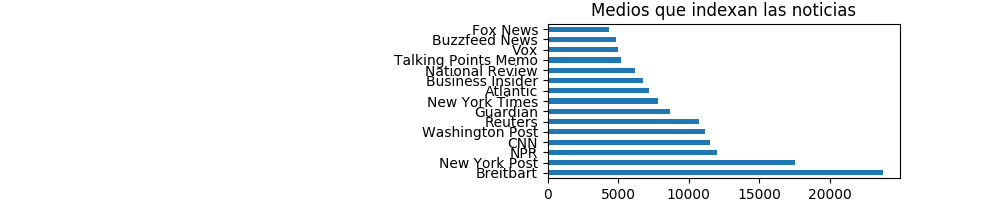

In [18]:
# tabla de frecuencia de medios que indexan las publicaciones
# en esta tabla quedan consignados los medios que publican las noticias
# que se encuantran consignadas en el dataset
pd.value_counts(df['publication'])

# grafico de barras de frecuencias de los medios que indexan las noticias
# en el grafico queda explicita la relacion de orden de mayor a menor 
# en el numero de noticias publicadas 
%matplotlib notebook


f = plt.figure(figsize=(10,2))
ax = f.add_subplot(122)
df['publication'].value_counts().plot(kind='barh',
                                            title='Medios que indexan las noticias', ax = ax)

<IPython.core.display.Javascript object>


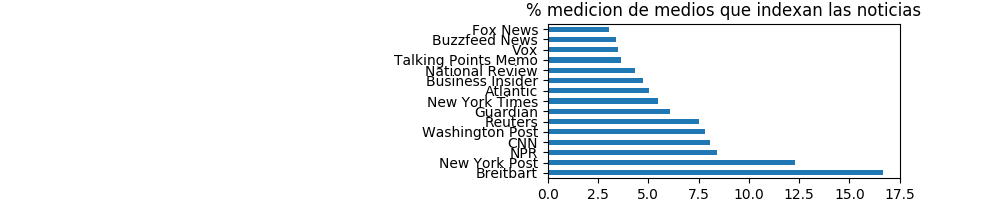

In [19]:
# tabla de frecuencias relativas para los medios que indexan las noticias
# de forma analoga a la abla anterior se mide el porcentaje de noticias
# que publica cada medio tomando como total todas las noticias del dataset
# grafico de barras de frecuencia relativa de los medios que indexan las noticias
# aqi queda consignado de manera grafica los porcentajes de publicaciones 
# que corresponden a cada medio
%matplotlib notebook
f = plt.figure(figsize=(10,2))
ax = f.add_subplot(122)
(100 * df['publication'].value_counts() / len(df['publication'])).plot(
                               kind='barh', title='% medicion de medios que indexan las noticias')

<IPython.core.display.Javascript object>


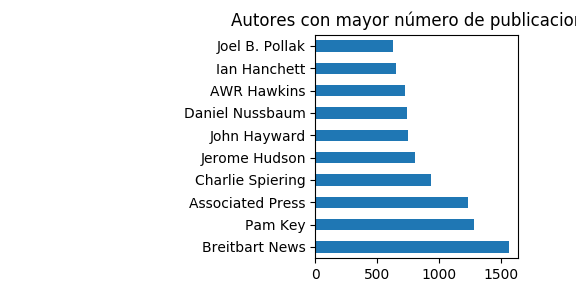

In [20]:
# la siguiente tabla deja ver de manera explicita
# los 11 autores con mayor numero de publicaciones
# relacionando autor con numero de publicaciones
AU = pd.value_counts(df['author'])
AU[0:10]

%matplotlib notebook
f = plt.figure(figsize=(10,2))
ax = f.add_subplot(122)
AU[0:10].plot( kind='barh', title='Autores con mayor número de publicaciones')

<IPython.core.display.Javascript object>


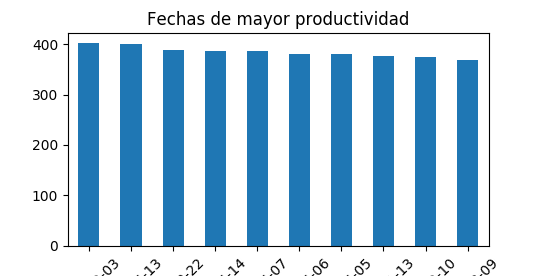

In [21]:
# la siguiente tabla muestra 
#las 11 fechas de mayor productividad

MS = pd.value_counts(df['date'])

MS[0:10]

#grafico de barras de las fechas con mayor indice
# de publicaciones y asociado su numero de publicaciones
%matplotlib notebook
f = plt.figure()
ax = f.add_subplot()
MS[0:10].plot(kind='bar',title= "Fechas de mayor productividad", ax = ax)
ax.tick_params(axis='x', labelrotation=45)

## Inverted index using metapy


In [8]:
#!rm -rf news-idx
idx = metapy.index.make_inverted_index('miniconfig.toml')

print(f'Total de documentos: {idx.num_docs()}')
print(f'Cantidad de palabras únicas: {idx.unique_terms()}')
print(f'Promedio de longitud de los documentos: {idx.avg_doc_length()}')


Total de documentos: 142570
Cantidad de palabras únicas: 298498
Promedio de longitud de los documentos: 378.13653564453125


# IR: Querys

In [9]:
ranker = metapy.index.OkapiBM25(k1=1.2, b=0.75)
query = metapy.index.Document()
query.content('Trump hates china') # query from AP news
top_docs = ranker.score(idx, query, num_results=5)

print(top_docs)
index=[tup[0] for tup in top_docs]
df.loc[index,['title','content']]


[(23373, 11.945362091064453), (55967, 10.423839569091797), (123632, 10.146553993225098), (119243, 9.89953327178955), (25871, 9.880447387695312)]


,title,content
23373,Ann Coulter: I Might Have Been Killed at the B...,"Ann Coulter, in a major interview with Vanity ..."
55967,A Trump Supporter Dwells in Beijing,BEIJING — Ardent Chinese supporters of Donald...
123632,"For Chinese officials, Trump perhaps better th...","In 2010, then Secretary of State Hillary Clin..."
119243,Massachusetts college apologizes for racist tw...,Salem State University President Patricia Mese...
25871,Donald Trump’s Hypocrisies - Breitbart,Part of Donald Trump’s appeal as a candidate i...


# LDA on spark

### Pre process data

Here we load data to spark and make some preprocessing over the text

In [10]:
#rawdata=spark.read.csv('aux.csv', inferSchema=True, header=True)

from nltk.stem import PorterStemmer, LancasterStemmer
from nltk.stem import WordNetLemmatizer

rawdata = spark.read.load("mini.csv", format="csv", header=True)

rawdata["all"].cast(StringType())




def cleanup_text(record):
    text  = record[1]
    uid   = record[0]
    
    # Default list of Stopwords
    sw = list(stop_words_nltk)
    

    tokens = nltk.word_tokenize(text)
    tokens = [ re.sub(r'[^A-Za-z0-9]+','',w) for w in tokens ] #Just letters and numbers
    tokens = [ w.lower() for w in tokens] #lowercase
    tokens = [ w for w in tokens if (len(w)>1) ] #Not single letter words
    tokens = [ w for w in tokens if w not in sw ] #Remove stopwords
    stemmer = PorterStemmer ()
    tokens =[stemmer.stem(token) for token in tokens]
    return tokens


udf_cleantext = udf(cleanup_text , ArrayType(StringType()))
clean_text = rawdata.withColumn("words", udf_cleantext(struct([rawdata[x] for x in rawdata.columns])))
clean_text.show()

+---+--------------------+--------------------+
|_c0|                 all|               words|
+---+--------------------+--------------------+
|  0|House Republicans...|[hous, republican...|
|  1|Rift Between Offi...|[rift, offic, res...|
|  2|Tyrus Wong, ‘Bamb...|[tyru, wong, bamb...|
|  3|Among Deaths in 2...|[among, death, 20...|
|  4|Kim Jong-un Says ...|[kim, jongun, say...|
|  5|Sick With a Cold,...|[sick, cold, quee...|
|  6|Taiwan’s Presiden...|[taiwan, presid, ...|
|  7|After ‘The Bigges...|[biggest, loser, ...|
|  8|First, a Mixtape....|[first, mixtap, r...|
|  9|Calling on Angels...|[call, angel, end...|
| 10|Weak Federal Powe...|[weak, feder, pow...|
| 11|Can Carbon Captur...|[carbon, captur, ...|
| 12|Mar-a-Lago, the F...|[maralago, futur,...|
| 13|How to form healt...|[form, healthi, h...|
| 14|Turning Your Vaca...|[turn, vacat, pho...|
| 15|As Second Avenue ...|[second, avenu, s...|
| 16|Dylann Roof Himse...|[dylann, roof, re...|
| 17|Modi’s Cash Ban B...|[modi, cash, b

### Embedings + LDA

here we create the features of each line and then make the LDA itself with k topics

In [11]:
# Term Frequency Vectorization  - Option 2 (CountVectorizer)    : 
cv = CountVectorizer(inputCol="words", outputCol="rawFeatures", minDF = clean_text.count()*0.05)
cvmodel = cv.fit(clean_text)
featurizedData = cvmodel.transform(clean_text)

vocab = cvmodel.vocabulary
vocab_broadcast = sc.broadcast(vocab)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

# Generate 25 Data-Driven Topics:
lda = LDA(k=5, seed=123, optimizer="em", featuresCol="features")

ldamodel = lda.fit(rescaledData)

#model.isDistributed()
#model.vocabSize()

ldatopics = ldamodel.describeTopics()
#ldatopics.show(25)

def map_termID_to_Word(termIndices):
    words = []
    for termID in termIndices:
        words.append(vocab_broadcast.value[termID])
    
    return words

udf_map_termID_to_Word = udf(map_termID_to_Word , ArrayType(StringType()))
ldatopics_mapped = ldatopics.withColumn("topic_desc", udf_map_termID_to_Word(ldatopics.termIndices))

### Show topics

In [12]:
ldatopics_mapped.select(ldatopics_mapped.topic, ldatopics_mapped.topic_desc).show(50,False)

+-----+------------------------------------------------------------------------------+
|topic|topic_desc                                                                    |
+-----+------------------------------------------------------------------------------+
|0    |[women, march, game, black, museum, play, season, player, art, feel]          |
|1    |[trump, republican, senat, democrat, law, mr, health, obama, insur, vote]     |
|2    |[ms, school, famili, student, mr, editor, mother, california, inaugur, reader]|
|3    |[attack, refuge, islam, kill, polic, dr, unit, mexico, prison, state]         |
|4    |[compani, russian, russia, percent, rate, la, trump, data, intellig, network] |
+-----+------------------------------------------------------------------------------+



### Add detected topic to each line

In [13]:
ldaResults = ldamodel.transform(rescaledData)

ldaResults.select('all','words','features','topicDistribution').show(10)

+--------------------+--------------------+--------------------+--------------------+
|                 all|               words|            features|   topicDistribution|
+--------------------+--------------------+--------------------+--------------------+
|House Republicans...|[hous, republican...|(1694,[0,1,2,3,4,...|[0.04723055895478...|
|Rift Between Offi...|[rift, offic, res...|(1694,[0,1,3,4,5,...|[0.26789445964289...|
|Tyrus Wong, ‘Bamb...|[tyru, wong, bamb...|(1694,[0,1,3,4,5,...|[0.66336737111457...|
|Among Deaths in 2...|[among, death, 20...|(1694,[0,1,3,4,5,...|[0.61118245185220...|
|Kim Jong-un Says ...|[kim, jongun, say...|(1694,[0,1,2,3,5,...|[0.06957133168475...|
|Sick With a Cold,...|[sick, cold, quee...|(1694,[1,3,6,9,13...|[0.35220465655261...|
|Taiwan’s Presiden...|[taiwan, presid, ...|(1694,[0,1,2,3,4,...|[0.07896991660498...|
|After ‘The Bigges...|[biggest, loser, ...|(1694,[0,1,3,4,5,...|[0.49453597547825...|
|First, a Mixtape....|[first, mixtap, r...|(1694,[0,1,

### Add principal topic to each line

In [14]:
from pyspark.sql.types import IntegerType


def foo(topicDistribution):
    dom = topicDistribution[0]
    index_dom = 0
    for index in range(len(topicDistribution)):
        if (topicDistribution[index]>dom):
            dom=topicDistribution[index]
            index_dom=index
    return index_dom

udf_seltop = udf(foo , IntegerType())
aaa = ldaResults.withColumn("topic_prin", udf_seltop(ldaResults.topicDistribution))


aaa.select('all','topic_prin').show(10)

+--------------------+----------+
|                 all|topic_prin|
+--------------------+----------+
|House Republicans...|         1|
|Rift Between Offi...|         3|
|Tyrus Wong, ‘Bamb...|         0|
|Among Deaths in 2...|         0|
|Kim Jong-un Says ...|         3|
|Sick With a Cold,...|         0|
|Taiwan’s Presiden...|         1|
|After ‘The Bigges...|         0|
|First, a Mixtape....|         2|
|Calling on Angels...|         0|
+--------------------+----------+
only showing top 10 rows



# Sentiment Analysis

In [15]:

def p_pol(x):
    if x > p66:
        return "positivo"
    elif x < p33:
        return "negativo"
    else:
        return "neutral"

def sentiment_func(news):
    try:
        return TextBlob(news).sentiment
    except:
        return None


    
    
df_pandas=aaa.select('all','topic_prin').toPandas()

df=df2.head(df_pandas.shape[0]).copy()
    
%time df['sentimientos'] = df['all'].apply(sentiment_func)

df['polaridad'] = df['sentimientos'].apply(lambda x: x[0])
df['Subjetividad'] = df['sentimientos'].apply(lambda x: x[1])


p33=np.percentile(df['polaridad'],33)
p66=np.percentile(df['polaridad'],66)

df['feeling']=df['polaridad'].apply(p_pol)





df=df[['all','polaridad','Subjetividad','feeling']].merge(df_pandas)

df.to_csv('Sentiments_news.csv')




CPU times: user 13.3 s, sys: 1.18 ms, total: 13.3 s
Wall time: 13.3 s
